In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as img


import numpy as np
import pathlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


In [2]:
torch.set_num_threads(4)
torch.set_num_interop_threads(4)

In [3]:
data_dir = 'Rice_Image_Dataset'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('Rice_Image_Dataset')

In [4]:
ar = list(data_dir.glob('Arborio/*'))[0]
ba = list(data_dir.glob('Basmati/*'))[0]
ip = list(data_dir.glob('Ipsala/*'))[0]
ja = list(data_dir.glob('Jasmine/*'))[0]
ka = list(data_dir.glob('Karacadag/*'))[0]


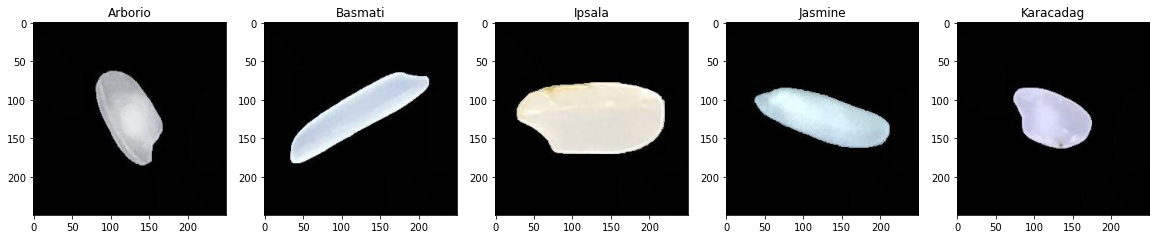

In [11]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))

ar_image = img.imread(ar)
ba_image = img.imread(ba)
ip_image = img.imread(ip)
ja_image = img.imread(ja)
ka_image = img.imread(ka)

ax[0].set_title('Arborio')
ax[1].set_title('Basmati')
ax[2].set_title('Ipsala')
ax[3].set_title('Jasmine')
ax[4].set_title('Karacadag')


ax[0].imshow(ar_image)
ax[1].imshow(ba_image)
ax[2].imshow(ip_image)
ax[3].imshow(ja_image)
ax[4].imshow(ka_image);

Set a transform

In [12]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

trainTransform = transforms.Compose([transforms.RandomRotation(5), #data augmentation
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     transforms.Resize(64)
                                    ])


dataset = ImageFolder(data_dir,transform = trainTransform)


Total number of data

In [13]:
len(dataset)

75000

Split data into train, validation, test dataset

In [14]:
trainDataset, valDataset, testDataset = torch.utils.data.random_split(dataset, (52500, 15000, 7500))

Size of tensor

In [16]:
img, label = trainDataset[0]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 64, 64]) tensor(-1.) tensor(1.)


Size of each dataset

In [11]:
print("Train dataset size:", len(trainDataset))
print("Validation dataset size:", len(valDataset))
print("Test dataset size:", len(testDataset))

Train dataset size: 52500
Validation dataset size: 15000
Test dataset size: 7500


Convert dataset into loader

In [12]:
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=4, shuffle=True, num_workers=2)
valLoader = torch.utils.data.DataLoader(valDataset, batch_size=4, shuffle=False, num_workers=2)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag')

CNN model

In [14]:
class CNNModel(nn.Module):
    def __init__(self, hiddenSize, outChannels, dropoutRate, activate):
        super().__init__()
        self.outChannels = outChannels
        self.activate = nn.Sigmoid() if activate == "Sigmoid" else nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, outChannels, 5)
        self.dense1 = nn.Linear(outChannels * 13 * 13, hiddenSize)
        self.dropout = nn.Dropout(dropoutRate)
        self.dense2 = nn.Linear(hiddenSize, 5)

    def forward(self, x):
        x = self.pool(self.activate(self.conv1(x)))
        x = self.pool(self.activate(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, self.outChannels * 13 * 13)
        x = self.dropout(self.activate(self.dense1(x)))
        return self.dense2(x)

In [15]:
# Number of neurons in the first fully-connected layer
hiddenSize = 100
# Number of feature filters in second convolutional layer
numFilters = 25
# Dropout rate
dropoutRate = 0
# Activation function
activation = "ReLU"
# Learning rate
learningRate = 0.001
# Momentum for SGD optimizer
momentum = 0.9
# Number of training epochs
numEpochs = 10

In [16]:
cnn = CNNModel(hiddenSize, numFilters, dropoutRate, activation)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(cnn.parameters()), lr=learningRate, momentum=momentum)

val_acc = []
test_acc = []

print('>>> Beginning training!') 
cnn.train()
for epoch in range(numEpochs):  # loop over the dataset multiple times
    cnnRunningLoss =  0
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        
        optimizer.zero_grad()

        # Forward propagation
        cnnOutputs = cnn(inputs)
        
        # Backpropagation
        cnnLoss = criterion(cnnOutputs, labels)
        
        cnnLoss.backward()
        
        # Gradient update
        optimizer.step()

        
        cnnRunningLoss += cnnLoss.item()
        #if (i+1) % 5000 == 0:    # print every 2000 mini-batches
        #    print(f'Epoch [{epoch + 1}/{numEpochs}], Step [{i + 1}/{len(trainDataset)//4}], CNN Loss: {cnnRunningLoss/5000}')
        #    cnnRunningLoss = 0
    print(f'Epoch [{epoch + 1}/{numEpochs}], CNN Loss: {cnnRunningLoss/52500}')
    

    cnn.eval()
    cnnCorrect = 0
    total = 0
    for inputs, labels in valLoader:
        cnnOutputs = cnn(inputs)
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        total += labels.size(0)
        cnnCorrect += (cnnPredicted == labels).sum().item()
    val_acc.append(cnnCorrect / total * 100)

    cnn.eval()
    cnnCorrect = 0
    total = 0
    for inputs, labels in testLoader:
        cnnOutputs = cnn(inputs)
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        total += labels.size(0)
        cnnCorrect += (cnnPredicted == labels).sum().item()
    test_acc.append(cnnCorrect / total * 100)

print()
print('>>> Beginning validation!')
cnn.eval()
cnnCorrect = 0
total = 0
for inputs, labels in valLoader:
    cnnOutputs = cnn(inputs)
    _, cnnPredicted = torch.max(cnnOutputs.data, 1)
    total += labels.size(0)
    cnnCorrect += (cnnPredicted == labels).sum().item()
print(f'CNN validation accuracy: {cnnCorrect / total * 100}%')
print(' ')
print(f'CNN validation accuracy: {val_acc[-1]}%')
print(f'CNN test accuracy: {test_acc[-1]}%')


>>> Beginning training!


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], CNN Loss: 0.03444563478155427
Epoch [2/10], CNN Loss: 0.013142071274610928
Epoch [3/10], CNN Loss: 0.010141861497645378
Epoch [4/10], CNN Loss: 0.0077747444209075485
Epoch [5/10], CNN Loss: 0.006582848462534511
Epoch [6/10], CNN Loss: 0.005821461906249554
Epoch [7/10], CNN Loss: 0.004658398598238484
Epoch [8/10], CNN Loss: 0.004288913347789759
Epoch [9/10], CNN Loss: 0.003347944796868165
Epoch [10/10], CNN Loss: 0.0032989099300087792

>>> Beginning validation!
CNN validation accuracy: 99.55333333333334%
 
CNN validation accuracy: 99.59333333333333%
CNN test accuracy: 99.45333333333333%


Accuracy of validation and test data by number of epoch

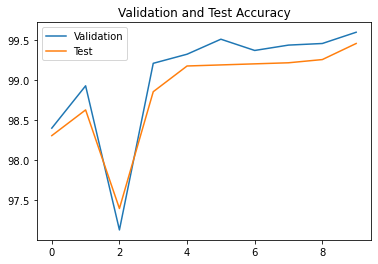

In [24]:
plt.title("Validation and Test Accuracy")
plt.plot(val_acc, label = 'Validation')
plt.plot(test_acc, label = 'Test')
plt.legend();